In [12]:
#TO DO:
#1) add frequency as numerical 0-... scale -- DONE
#2) plot CUDIT and freq vs. acc and RT -- DONE
#3) add same regressors to group comparisons; though probably not CUDIT and frequ -- DONE
#4) do the same with mid -- DONE
#5) subgroup analyses: depress/anx/insom/pain; CUD; cannabis in urine; only who performed well 
#6) compare MM 1year with HC baseline

In [13]:
import os
import pandas as pd
import numpy as np
import re
import glob
import json
import nibabel 
import nilearn
from nilearn import plotting 
from nilearn.plotting import plot_glass_brain
from nilearn.glm.second_level import SecondLevelModel
from nilearn.masking import intersect_masks
from nilearn.image import math_img
from nilearn.glm import threshold_stats_img
import matplotlib.pyplot as plt

In [14]:
#get 3 group means

In [42]:
def get_group_average_contrast(contrast,ses,group,task,covariates,subgroup):
    print('Now processing: '+ ' '.join([contrast,ses,group,task]))
    space='MNI152NLin6Asym' 

    #get individual effect size maps
    effect_size_maps = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-*_contrast-{contrast}_effect_size.nii.gz')
    
    #ensure we have data
    if not effect_size_maps:
        print('No effect size maps, so cannot generate group level output for: '+' '.join([contrast,ses,group,task]))
        return (None, None, None)    
    
    
    #note that subject formatting is changed slightly to match that of the non_imaging_data csv file
    #need these to make design matrix
    subs = [path.split('/sub-')[1].split('/')[0] for path in effect_size_maps if path]
    subs_csv = ['_'.join([s for s in re.split(r'(MM|HC)', sub) if s]) for sub in subs]

    if subgroup:
        effect_size_maps, subs_csv, subs = select_subgroup(subgroup, effect_size_maps, subs_csv, subs)

    #needed for printing total later
    part_count = len(subs_csv)
        
    
    #create design matrix including all covariates and a way to encode group average (either as col of 1s or with Male/Female)
    group_design_matrix = create_group_design_matrix(subs_csv,group,ses,covariates)
    
    
    #grab masks needed
    masks = []
    for sub in subs:
        masks+=glob.glob(f'../../../derivatives/ses-{ses}/sub-{sub}*/ses-{ses}/func/sub-{sub}*task-{task}*rec-unco*run-*_*{space}*brain_mask.nii.gz')

        
    #make intersection of the masks
    #threshold=1 corresponds to keeping the intersection of all masks, whereas threshold=0 is the union of all masks
    mask = intersect_masks(masks, threshold=1, connected=True)

    
    cache_loc = './nilearn_cache' #change if desired

    #define model specs
    second_level_model = SecondLevelModel(mask_img=mask, target_affine=None, target_shape=None, 
                                          smoothing_fwhm=None, memory=cache_loc, memory_level=1, 
                                          verbose=0, n_jobs=-2, minimize_memory=False)
    
    #fit model
    second_level_model = second_level_model.fit(effect_size_maps, design_matrix=group_design_matrix,)

    
    #define contrast matrix 
    contrast_matrix = np.eye(group_design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                      for i, column in enumerate(group_design_matrix.columns)])
    
    #here we do a group average or focus on the cudit slope if part of covariates:
    if 'total_cudit' in covariates:
        grp_contrast = contrasts['total_cudit']
    elif 'THC_freq_month' in covariates:
        grp_contrast = contrasts['THC_freq_month']
    elif 'sex' in covariates:
        grp_contrast = 0.5*contrasts['Female']+0.5*contrasts['Male']
    else:
        grp_contrast = contrasts['group_average']
    
    print(grp_contrast)
    
    #compute the group average contrast
    #pick stat_type none because it automatically selects t vs. F test 
    contrast_output = second_level_model.compute_contrast(second_level_contrast=grp_contrast, 
                                                          second_level_stat_type=None, output_type='all')
    
    #for printing the covariates
    if covariates == '':
        covariates = 'nothing'
        
    print('Processing done for: '+' '.join([contrast,ses,group,task]))
    print(f'Controlled for {covariates}')

    return (contrast_output, mask, part_count)



In [43]:
def select_subgroup(subgroup, effect_size_maps, subs_csv, subs):
    non_img_data = pd.read_csv(f"../../../sourcedata/non_imaging_data/MMJ-Processed_data-2022_05_27-13_58-6858bbe.csv",low_memory=False)
    final_subs = []
    final_subs_csv = []
    final_effect_size_maps = []
    if subgroup == 'dipstick_THC':
        dipstick_THC_results_dict = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'One year'].groupby('IDS.CHR.Subject')['URN.LGC.THC_present'].agg("first").to_dict()
        for i in range(len(effect_size_maps)):
            if dipstick_THC_results_dict[subs_csv[i]]:
                final_subs.append(subs[i])
                final_subs_csv.append(subs_csv[i])
                final_effect_size_maps.append(effect_size_maps[i])
    
    elif subgroup == 'alltime_CUD':
        #TO DO
        
                
    return (final_effect_size_maps, final_subs_csv, final_subs)
    
    

In [34]:
non_img_data = pd.read_csv(f"../../../sourcedata/non_imaging_data/MMJ-Processed_data-2022_05_27-13_58-6858bbe.csv",low_memory=False)

data_dict = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'One year'].groupby('IDS.CHR.Subject')['CUD.LGC.Diagnosis'].agg("first").to_dict()

data_dict


{'MM_010': True,
 'MM_011': None,
 'MM_013': False,
 'MM_014': True,
 'MM_015': False,
 'MM_016': False,
 'MM_020': False,
 'MM_024': False,
 'MM_025': True,
 'MM_027': False,
 'MM_028': False,
 'MM_032': False,
 'MM_035': True,
 'MM_036': None,
 'MM_037': True,
 'MM_042': True,
 'MM_043': False,
 'MM_044': True,
 'MM_050': False,
 'MM_053': False,
 'MM_054': True,
 'MM_055': False,
 'MM_062': False,
 'MM_064': False,
 'MM_069': None,
 'MM_070': False,
 'MM_074': True,
 'MM_075': True,
 'MM_080': False,
 'MM_085': False,
 'MM_086': False,
 'MM_089': False,
 'MM_091': False,
 'MM_092': False,
 'MM_095': True,
 'MM_096': None,
 'MM_100': False,
 'MM_103': True,
 'MM_104': False,
 'MM_105': True,
 'MM_106': True,
 'MM_108': None,
 'MM_110': False,
 'MM_112': False,
 'MM_114': None,
 'MM_115': False,
 'MM_116': False,
 'MM_120': None,
 'MM_122': False,
 'MM_127': False,
 'MM_128': False,
 'MM_129': False,
 'MM_130': True,
 'MM_131': False,
 'MM_132': True,
 'MM_134': False,
 'MM_135': True

In [35]:
def create_group_design_matrix(subs,group,ses,covariates):
    #TO DO: add mean FD
    
    df_subs = pd.DataFrame(subs,columns=['subs'])
    non_img_data = pd.read_csv(f"../../../sourcedata/non_imaging_data/MMJ-Processed_data-2022_05_27-13_58-6858bbe.csv",low_memory=False)
    dummy_dfs = []
    
    if 'sex' not in covariates:
        #create design matrix with 1 column of 1s and as many rows as there are subjects
        group_design_matrix = pd.DataFrame([1] * len(subs), columns=['group_average'],)
    
    else:
        #create empty design matrix to add to
        group_design_matrix = pd.DataFrame()
        #add columns for male and female, that will then be combined to create the group average 
        grouped_sex = non_img_data.groupby("IDS.CHR.Subject")["SBJ.CHR.Sex"].agg("first")
        dict_sex = grouped_sex.to_dict()
        df_subs['sex'] = df_subs['subs'].map(dict_sex)
        dummy_dfs.append(pd.get_dummies(df_subs['sex']))
    
    #numericals can be added directly
    #mean center numerical values like age and CUDIT!

    if 'age' in covariates:
        #numerical can be added directly
        #mean center numerical value
        grouped_age = non_img_data.groupby("IDS.CHR.Subject")["SBJ.INT.Age"].agg("first")
        dict_age = grouped_age.to_dict()
        group_design_matrix['age'] = df_subs['subs'].map(dict_age)
        group_design_matrix['age'] = group_design_matrix['age'] - group_design_matrix['age'].mean()
    
    if 'total_cudit' in covariates:
        if group == 'HC': 
            grouped_HC_baseline_cudit = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Screening'].groupby('IDS.CHR.Subject')['INV.INT.CUDIT.Summed_score'].agg("first")
            dict_HC_baseline_cudit = grouped_HC_baseline_cudit.to_dict()
            group_design_matrix['total_cudit'] = df_subs['subs'].map(dict_HC_baseline_cudit)
            group_design_matrix['total_cudit'] = group_design_matrix['total_cudit'] - group_design_matrix['total_cudit'].mean()

        else:
            if ses == 'baseline':
                dict_MM_baseline_cudit = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Baseline'].groupby('IDS.CHR.Subject')['INV.INT.CUDIT.Summed_score'].agg("first").to_dict()
                group_design_matrix['total_cudit'] = df_subs['subs'].map(dict_MM_baseline_cudit)
                group_design_matrix['total_cudit'] = group_design_matrix['total_cudit'] - group_design_matrix['total_cudit'].mean()
                #needed because MM_141 is nan, so replacing with 0, which is the mean
                group_design_matrix['total_cudit'].fillna(0, inplace=True)
            else:
                dict_MM_1year_cudit = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'One year'].groupby('IDS.CHR.Subject')['INV.INT.CUDIT.Summed_score'].agg("first").to_dict()
                group_design_matrix['total_cudit'] = df_subs['subs'].map(dict_MM_1year_cudit)
                group_design_matrix['total_cudit'] = group_design_matrix['total_cudit'] - group_design_matrix['total_cudit'].mean()
    
    #encode the correspondence 
    freq_dict = {'Once or more per day':7,
        '5-6 days a week':6,
        '3-4 days a week':5,
        '1-2 days a week':4,
        'Less than once a week':3,
        'Less than once every two weeks':2,
        'Less than once a month':1,
        None:0}
    
    if 'THC_freq_month' in covariates:
        if group == 'HC':
            #results from screening visit (using this for consistency since CUDIT-R was also collected at screening visit)
            dict_HC_screening_THC = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Screening'].groupby('IDS.CHR.Subject')['TLF.CHR.THC.Frequency_in_month'].agg("last").to_dict()
            dict_HC_screening_THC_num = {k:freq_dict[v] for k,v in dict_HC_screening_THC.items()}
            group_design_matrix['THC_freq_month'] = df_subs['subs'].map(dict_HC_screening_THC_num)
            group_design_matrix['THC_freq_month'] = group_design_matrix['THC_freq_month'] - group_design_matrix['THC_freq_month'].mean()
        else:
            if ses == 'baseline':     
                #results from MRI visit (using this for consistency since CUDIT-R was also collected at MRI visit)
                dict_MM_MRIvisit_THC = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'Baseline'].groupby('IDS.CHR.Subject')['TLF.CHR.THC.Frequency_in_month'].agg("first").to_dict()
                dict_MM_MRIvisit_THC_num = {k:freq_dict[v] for k,v in dict_MM_MRIvisit_THC.items()}
                group_design_matrix['THC_freq_month'] = df_subs['subs'].map(dict_MM_MRIvisit_THC_num)
                group_design_matrix['THC_freq_month'] = group_design_matrix['THC_freq_month'] - group_design_matrix['THC_freq_month'].mean()
            else:
                dict_MM_MRIvisit_THC = non_img_data[non_img_data['SSS.CHR.Time_point'] == 'One year'].groupby('IDS.CHR.Subject')['TLF.CHR.THC.Frequency_in_month'].agg("first").to_dict()
                dict_MM_MRIvisit_THC_num = {k:freq_dict[v] for k,v in dict_MM_MRIvisit_THC.items()}
                group_design_matrix['THC_freq_month'] = df_subs['subs'].map(dict_MM_MRIvisit_THC_num)
                group_design_matrix['THC_freq_month'] = group_design_matrix['THC_freq_month'] - group_design_matrix['THC_freq_month'].mean()

                
    #add all items to design matrix that are still missing
    group_design_matrix = pd.concat([group_design_matrix]+dummy_dfs,axis=1,copy=False)
    
    return group_design_matrix



In [36]:
def fdr_threshold_map(z_map,mask):
    threshold_map, threshold = threshold_stats_img(z_map, mask_img=mask, alpha=0.05, height_control='fdr', cluster_threshold=0, two_sided=True)
    return (threshold_map, threshold)

    

In [37]:
def plot_axial_slices(threshold_map, threshold, MNI_template_used, contrast, group, ses, part_count):
    
    display = plotting.plot_stat_map(threshold_map, bg_img = MNI_template_used, display_mode='z', cut_coords=[-28,0,28,40,60],
                       threshold=threshold)
    
    if threshold:
        rounded_thresh = round(threshold,2)
        display.title(text=f'Thresholded z map; "{contrast}" contrast of {group} at {ses}, exp. fdr = .05, z_thresh = {rounded_thresh}, n = {part_count}', size=14, y=1.2)
    else:
        display.title(text=f'Effect size map; "{contrast}" contrast of {group} at {ses}, n = {part_count}', size=14, y=1.2)
    return display
    


In [38]:
def plot_glass_brains(threshold_map, threshold, contrast, group, ses, part_count):
    display = plot_glass_brain(
    stat_map_img = threshold_map,
    threshold=threshold,
    colorbar=True,
    display_mode='ortho',
    plot_abs=False)
    rounded_thresh = round(threshold,2)
    display.title(text=f'Z scores on glass brain; "{contrast}" contrast of {group} at {ses}, exp. fdr = .05, z_thresh = {rounded_thresh}, n = {part_count}',
                  size=14, y=1.2)
    return display

Now processing: twoback-zeroback 1year MM nback
['MM_028', 'MM_044', 'MM_053', 'MM_054', 'MM_062', 'MM_075', 'MM_085', 'MM_086', 'MM_091', 'MM_095', 'MM_096', 'MM_100', 'MM_103', 'MM_104', 'MM_112', 'MM_122', 'MM_127', 'MM_129', 'MM_131', 'MM_132', 'MM_135', 'MM_136', 'MM_140', 'MM_147', 'MM_148', 'MM_151', 'MM_154', 'MM_160', 'MM_166', 'MM_177', 'MM_179', 'MM_188', 'MM_193', 'MM_195', 'MM_196', 'MM_197', 'MM_198', 'MM_199', 'MM_207', 'MM_217', 'MM_221', 'MM_224', 'MM_227', 'MM_230', 'MM_232', 'MM_239', 'MM_240', 'MM_241', 'MM_248', 'MM_249', 'MM_254', 'MM_256', 'MM_273', 'MM_284', 'MM_286', 'MM_301', 'MM_315', 'MM_330', 'MM_334']
False
True
False
True
False
True
False
False
False
True
None
False
True
False
False
False
False
False
False
True
True
False
True
False
True
False
False
False
False
False
True
True
False
False
False
False
False
True
True
False
False
True
False
True
True
True
False
True
False
True
None
False
False
True
False
None
True
True
True
['MM_044', 'MM_054', 'MM_075', 'M

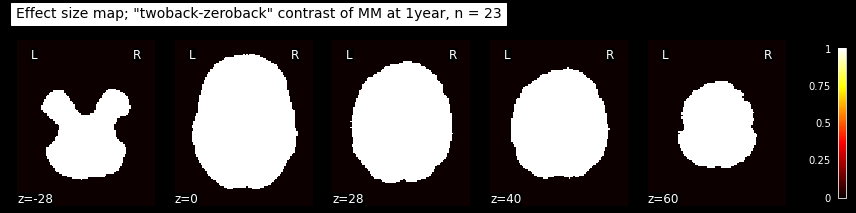

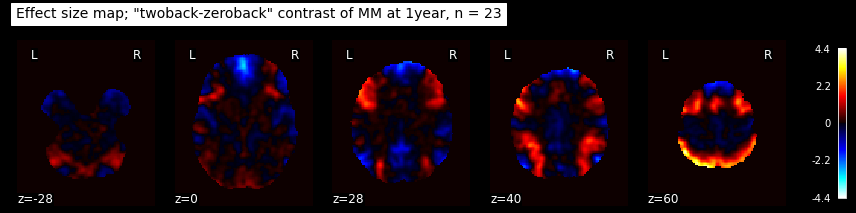

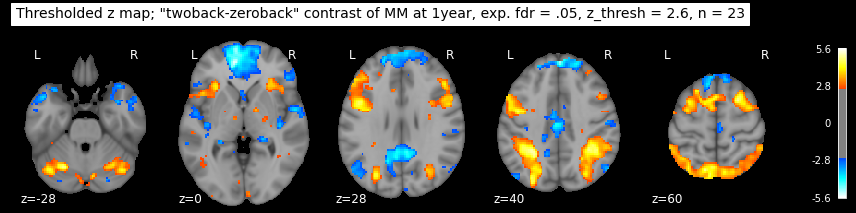

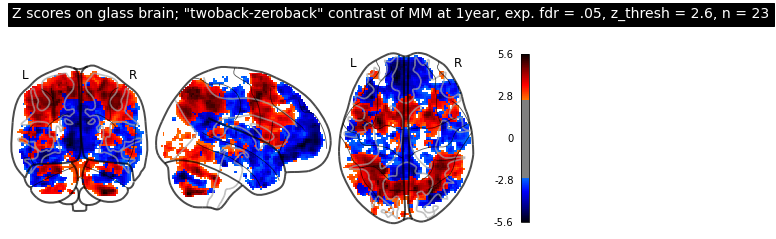

In [39]:
task='nback'
sessions = ['1year']
contrasts=['twoback-zeroback']
groups = ['MM'] 
MNI_template_used = nibabel.load('./templates/tpl-MNI152NLin6Asym_res-01_desc-brain_T1w.nii.gz')

#options are age, sex, total_cudit, THC_freq_month at the moment
#note that if total_cudit or THC_freq_month are selected, the zmap is for their slopes, not for the group average slope
covariates = ['sex','age']

subgroup = 'dipstick_THC' #options: '' (aka include all), depr-anx', 'pain', 'insomnia', 'alltime_CUD' (only for baseline MM), 'dipstick_THC' (only for 1year), 'good_performance'

#TO DO: make this into script
#loop through all sessions, groups, contrasts
for ses in sessions:
    for group in groups:
        for contrast in contrasts:
            #get group average group level contrast as the output
            contrast_output, mask, part_count = get_group_average_contrast(contrast,ses,group,task,covariates,subgroup)
            
            #account for HC not having 1year scans
            if contrast_output:
                #compute FDR-corrected z-score thresholdmap
                #note that this does not have a cluster threshold
                #this image is masked by the mask intersection across all subjects
                threshold_map, threshold = fdr_threshold_map(contrast_output['z_score'], mask)

                #make desired plots (mask and effect size as sanity checks; zmap and z glass brain)
                mask_axial_slices = plot_axial_slices(mask, None, MNI_template_used, contrast, group, ses, part_count)
                
                effect_axial_slices = plot_axial_slices(contrast_output['effect_size'], None, MNI_template_used, contrast, group, ses, part_count)
               
                zmap_axial_slices = plot_axial_slices(threshold_map, threshold, MNI_template_used, contrast, group, ses, part_count)
                
                zmap_glass_brain = plot_glass_brains(threshold_map, threshold, contrast, group, ses, part_count)



In [ ]:
#group difference model for control vs. MM at baseline 

In [9]:
def get_baseline_group_difference_contrast(contrast,ses,groups,task,covariates):
    
    #get individual effect size maps and a design matrix per group
    effect_size_maps=[] #list of both groups effect size maps
    group_sizes=[] #list of the two group sizes
    group_design_matrices=[] #get separate design matrices per group that will be combined
    for group in groups:
        effect_size_maps_by_group = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-*_contrast-{contrast}_effect_size.nii.gz')
        effect_size_maps += effect_size_maps_by_group
        group_sizes.append(len(effect_size_maps_by_group))
        
        #note that subject formatting is changed slightly to match that of the non_imaging_data csv file
        #need these to make design matrix
        subs = [path.split('/sub-')[1].split('/')[0] for path in effect_size_maps_by_group if path]
        subs = ['_'.join([s for s in re.split(r'(MM|HC)', sub) if s]) for sub in subs]
        
        #create design matrix per group
        #note that the columns that need to stay separate when stacking the design matrices later get renamed
        indv_design_matrix = create_group_design_matrix(subs,group,ses,covariates)
        if 'sex' in covariates:
            indv_design_matrix.rename({'Female': f'Female_{group}', 'Male': f'Male_{group}'}, axis='columns',inplace=True)
        else:
            indv_design_matrix.rename({'group_average': f'group_average_{group}'}, axis='columns',inplace=True)
        group_design_matrices.append(indv_design_matrix)
    
    
    #stack design matrices of the two groups to make one large design matrix
    #note again that group_average or Male&Female columns, which were renamed, will not get stacked
    #thus, these will partially contain NaNs, which will be replaced by 0s
    group_design_matrix = pd.concat(group_design_matrices).replace(np. nan,0) 

    
    #grab masks needed (both groups at baseline)
    masks = glob.glob(f'../../../derivatives/ses-{ses}/sub-*/ses-{ses}/func/sub-*task-{task}*rec-unco*run-*_*{space}*brain_mask.nii.gz')

    #make intersection of the masks
    #threshold=1 corresponds to keeping the intersection of all masks, whereas threshold=0 is the union of all masks
    mask = intersect_masks(masks, threshold=1, connected=True)
    
    
    #define group level model
    cache_loc = './nilearn_cache' #change if desired

    second_level_model = SecondLevelModel(mask_img=mask, target_affine=None, target_shape=None, 
                                      smoothing_fwhm=None, memory=cache_loc, memory_level=1, 
                                      verbose=0, n_jobs=-2, minimize_memory=False)
    #fit model
    second_level_model = second_level_model.fit(
        effect_size_maps,
        design_matrix=group_design_matrix,
    )

    #make list of possible contrasts: HC only, MM only, MM-HC
    contrast_matrix = np.eye(group_design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(group_design_matrix.columns)])
    
    
    #here we do a group average difference either just using a column of ones for each group or include the Male/Female columns
    if 'sex' in covariates:
        grp_contrast = 0.5*contrasts['Female_MM']+0.5*contrasts['Male_MM']-0.5*contrasts['Female_HC']-0.5*contrasts['Male_HC']
    else:
        grp_contrast = contrasts['group_average_MM']-contrasts['group_average_HC']
    
    print(grp_contrast)
    
    
    contrast_output = second_level_model.compute_contrast(second_level_contrast=grp_contrast, 
                                                          second_level_stat_type=None, output_type='all')
    
    #for printing the covariates
    if covariates == '':
        covariates = 'nothing'
        
    print('Processing done of the baseline difference of MM and HC for: '+' '.join([contrast,task]))
    print(f'Controlled for {covariates}')

    
    return (contrast_output, mask,(group_sizes[0],group_sizes[1]))



[ 1. -1.]
Processing done of the baseline difference of MM and HC for: twoback-zeroback nback
Controlled for []


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.6363161126315955. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


[]


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 0.5  0.5 -0.5 -0.5]
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 0.652977, ..., -0.022546],
       ...,
       [-1.60602 , ..., -0.221873]]), 
array([[1., ..., 0.],
       ...,
       [0., ..., 0.]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.glm.contrasts.compute_contrast...
compute_contrast(array([0., ..., 0.]), {0.0: <nilearn.glm.regression.RegressionResults object at 0x2aecfd662c10>}, array([ 0.5,  0.5, -0.5, -0.5]), None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.974276, ..., -0.403489]), <nibabel.nifti1.Nifti1Image object at 0x2aecfd662220>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.97964, ..., -0.40481]), <nibabel.nifti1.Nifti1Image object at 0x2aecfd662220>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.16496 , ..., 0.656706]), <nibabel.nifti1.Nifti1Image object at 0x2aecfd662220>)
___________________________________________________________unmask - 0.3s, 0.0min
______________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.293675846221011. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['sex']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 1.  0. -1.]
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 0.652977, ..., -0.022546],
       ...,
       [-1.60602 , ..., -0.221873]]), 
array([[1., ..., 0.],
       ...,
       [0., ..., 1.]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.glm.contrasts.compute_contrast...
compute_contrast(array([0., ..., 0.]), {0.0: <nilearn.glm.regression.RegressionResults object at 0x2aecfff74ac0>}, array([ 1.,  0., -1.]), None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.815299, ..., -0.40591 ]), <nibabel.nifti1.Nifti1Image object at 0x2aecfff747c0>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.819086, ..., -0.407226]), <nibabel.nifti1.Nifti1Image object at 0x2aecfff747c0>)
___________________________________________________________unmask - 0.2s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.207451, ..., 0.657596]), <nibabel.nifti1.Nifti1Image object at 0x2aecfff747c0>)
___________________________________________________________unmask - 0.2s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.628812048709128. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['age']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 1.  0. -1.]
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 0.652977, ..., -0.022546],
       ...,
       [-1.60602 , ..., -0.221873]]), 
array([[1., ..., 0.],
       ...,
       [0., ..., 1.]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.glm.contrasts.compute_contrast...
compute_contrast(array([0., ..., 0.]), {0.0: <nilearn.glm.regression.RegressionResults object at 0x2aed047eed00>}, array([ 1.,  0., -1.]), None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.804154, ..., -0.406194]), <nibabel.nifti1.Nifti1Image object at 0x2aed047ee520>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.807849, ..., -0.407512]), <nibabel.nifti1.Nifti1Image object at 0x2aed047ee520>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.210654, ..., 0.6577  ]), <nibabel.nifti1.Nifti1Image object at 0x2aed047ee520>)
___________________________________________________________unmask - 0.2s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.615995196519005. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['THC_freq_month']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 1.  0. -1.]
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 0.652977, ..., -0.022546],
       ...,
       [-1.60602 , ..., -0.221873]]), 
array([[1., ..., 0.],
       ...,
       [0., ..., 1.]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.glm.contrasts.compute_contrast...
compute_contrast(array([0., ..., 0.]), {0.0: <nilearn.glm.regression.RegressionResults object at 0x2aed053bdfa0>}, array([ 1.,  0., -1.]), None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.8s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.810133, ..., -0.402371]), <nibabel.nifti1.Nifti1Image object at 0x2aed053bda90>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.813877, ..., -0.403673]), <nibabel.nifti1.Nifti1Image object at 0x2aed053bda90>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.208932, ..., 0.656294]), <nibabel.nifti1.Nifti1Image object at 0x2aed053bda90>)
___________________________________________________________unmask - 0.3s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.611849028036328. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['total_cudit']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 0.   0.5  0.5 -0.5 -0.5]
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 0.652977, ..., -0.022546],
       ...,
       [-1.60602 , ..., -0.221873]]), 
array([[18.327869, ...,  0.      ],
       ...,
       [30.21875 , ...,  0.      ]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.glm.contrasts.compute_contrast...
compute_contrast(array([0., ..., 0.]), {0.0: <nilearn.glm.regression.RegressionResults object at 0x2aed059c4af0>}, array([ 0. ,  0.5,  0.5, -0.5, -0.5]), None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.81s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.920104, ..., -0.362623]), <nibabel.nifti1.Nifti1Image object at 0x2aed05d64a90>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.924956, ..., -0.363791]), <nibabel.nifti1.Nifti1Image object at 0x2aed05d64a90>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.178759, ..., 0.641557]), <nibabel.nifti1.Nifti1Image object at 0x2aed05d64a90>)
___________________________________________________________unmask - 0.3s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.256872127158674. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['age', 'sex']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 0.   0.   0.5  0.5 -0.5 -0.5]
Processing done of the baseline difference of MM and HC for: twoback-zeroback nback
Controlled for ['THC_freq_month', 'age', 'sex']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.243738220899063. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['THC_freq_month', 'age', 'sex']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


[ 0.   0.   0.5  0.5 -0.5 -0.5]
________________________________________________________________________________
[Memory] Calling nilearn.glm.first_level.first_level.run_glm...
run_glm(array([[ 0.652977, ..., -0.022546],
       ...,
       [-1.60602 , ..., -0.221873]]), 
array([[18.327869, ...,  0.      ],
       ...,
       [30.21875 , ...,  0.      ]]), n_jobs=-2, noise_model='ols')
__________________________________________________________run_glm - 1.1s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.glm.contrasts.compute_contrast...
compute_contrast(array([0., ..., 0.]), {0.0: <nilearn.glm.regression.RegressionResults object at 0x2aed06ff1ee0>}, array([ 0. ,  0. ,  0.5,  0.5, -0.5, -0.5]), None)


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/glm/second_level/second_level.py:515: UserWarning: Persisting input arguments took 0.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  contrast = mem_contrast(self.labels_, self.results_, con_val,


_________________________________________________compute_contrast - 0.9s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.919615, ..., -0.356096]), <nibabel.nifti1.Nifti1Image object at 0x2aed06ff12b0>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([ 0.924518, ..., -0.357252]), <nibabel.nifti1.Nifti1Image object at 0x2aed06ff12b0>)
___________________________________________________________unmask - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.178887, ..., 0.639116]), <nibabel.nifti1.Nifti1Image object at 0x2aed06ff12b0>)
___________________________________________________________unmask - 0.3s, 0.0min
____________

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.2320720865349735. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "


['total_cudit', 'age', 'sex']


/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


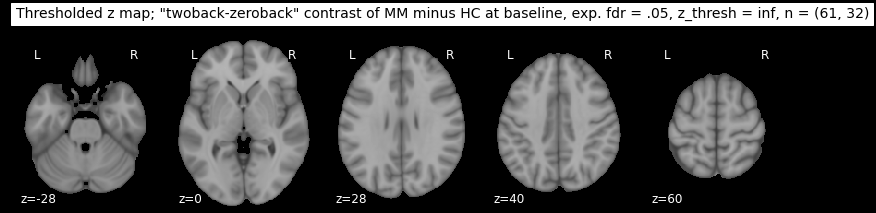

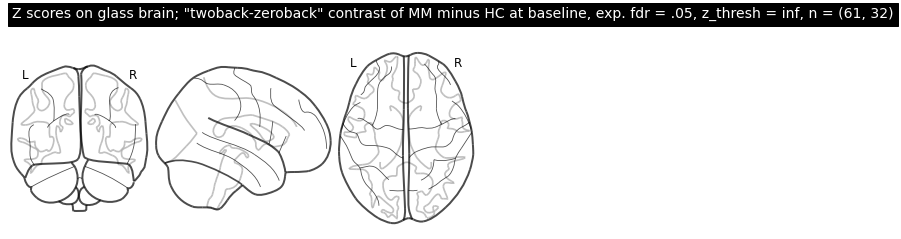

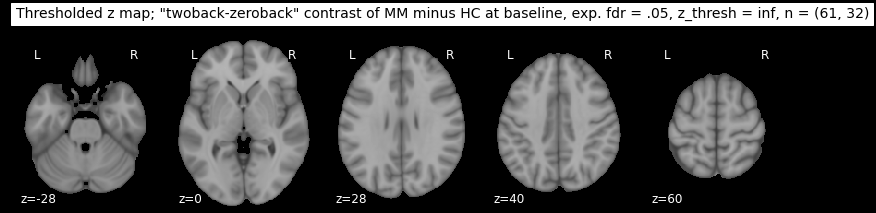

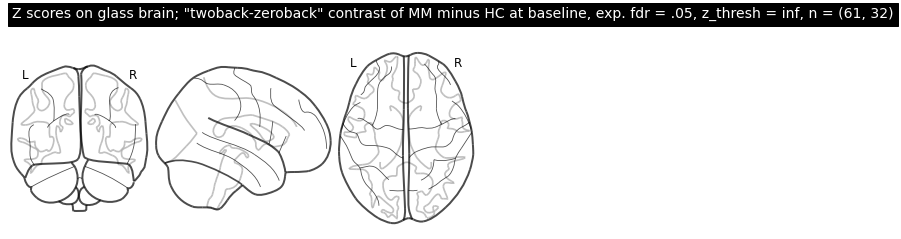

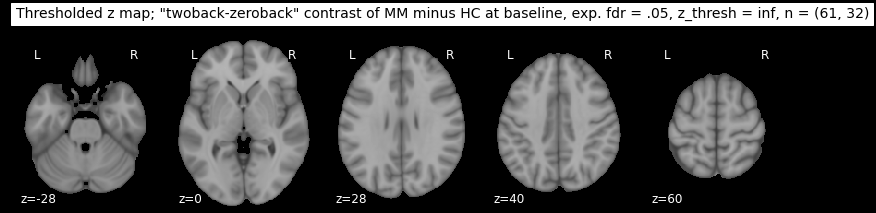

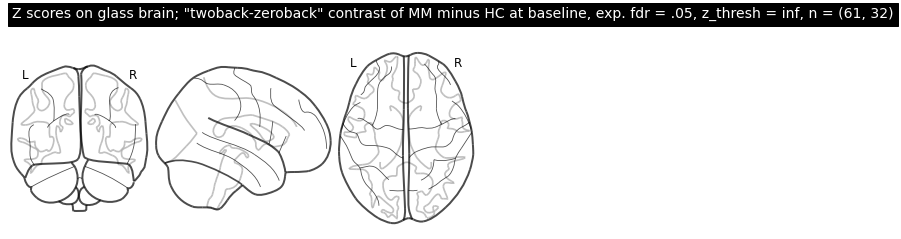

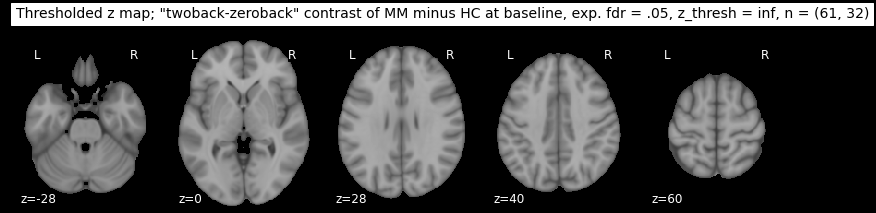

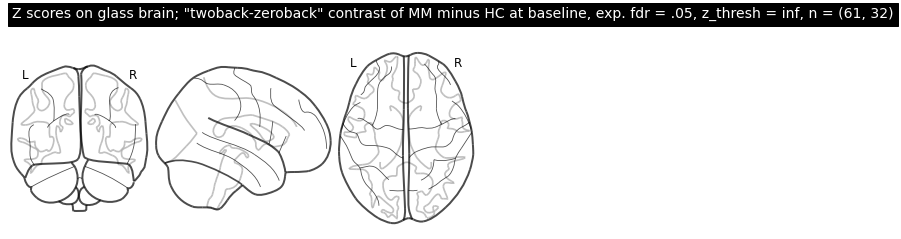

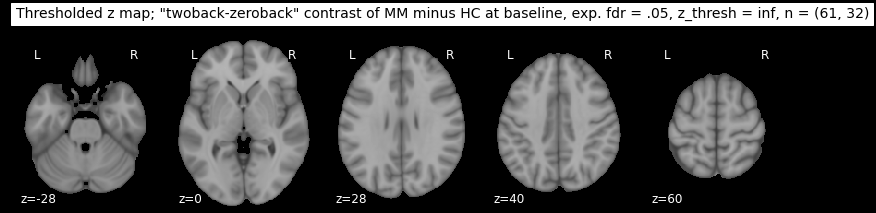

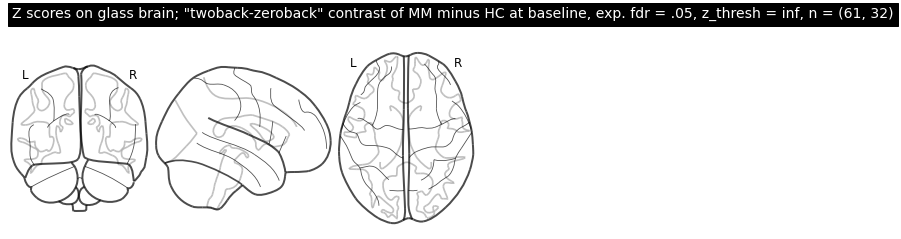

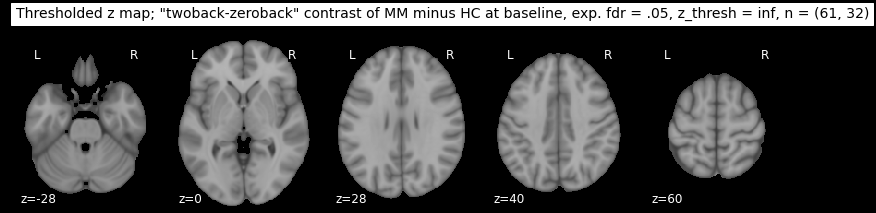

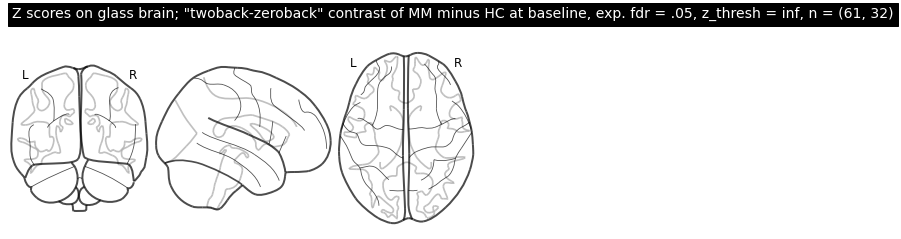

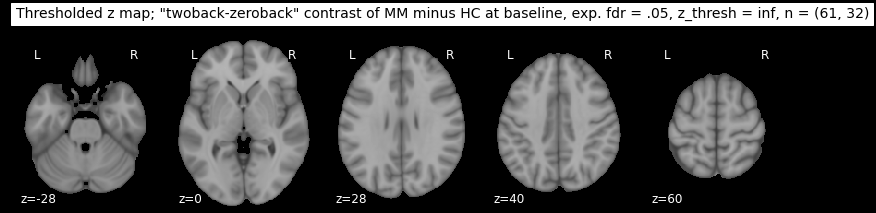

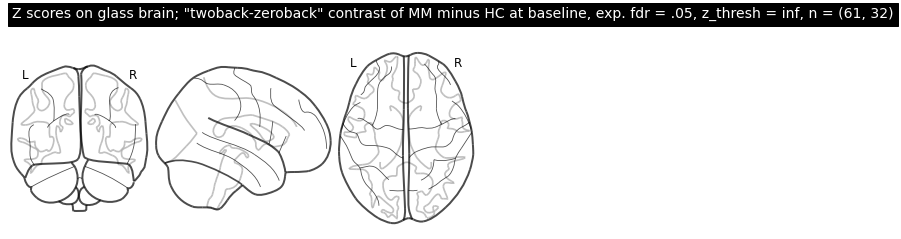

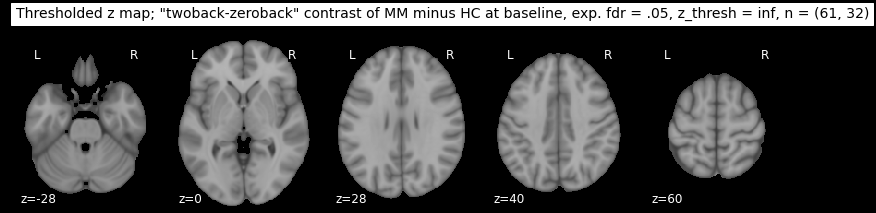

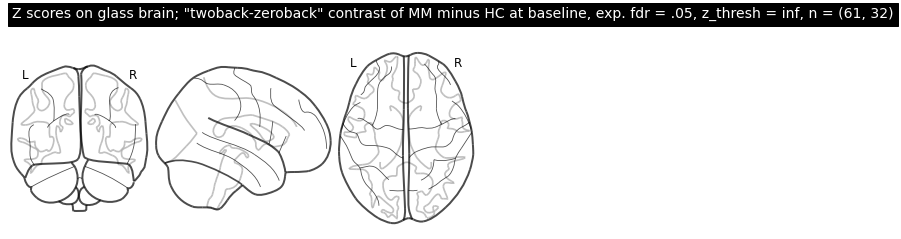

In [52]:
groups=['MM','HC']
ses='baseline'
task='nback'
contrasts=['twoback-zeroback']
space='MNI152NLin6Asym' #change if desired
covariates_list = [[],['sex'],['age'],['THC_freq_month'],['total_cudit'],['age','sex'],['THC_freq_month','age','sex'],['total_cudit','age','sex'] ]
MNI_template_used = nibabel.load('./templates/tpl-MNI152NLin6Asym_res-01_desc-brain_T1w.nii.gz')



#TO: loop through all contrasts
for covariates in covariates_list:
    for contrast in contrasts:
        #compute group difference contrast
        contrast_output, mask, part_count = get_baseline_group_difference_contrast(contrast,ses,groups,task,covariates)

        #calculate fdr-thresholded map
        threshold_map, threshold = fdr_threshold_map(contrast_output['z_score'], mask)
        print(covariates)
        #make visualizations
        axial_slices = plot_axial_slices(threshold_map, threshold, MNI_template_used, contrast, 'MM minus HC', ses, part_count)
        glass_brain = plot_glass_brains(threshold_map, threshold, contrast, 'MM minus HC', ses, part_count)

    

In [ ]:
#PAIRED group difference model for MM at 1year vs. baseline

In [40]:
def get_MM_paired_group_difference_contrast(contrast,sessions,group,task,covariates):
    
    #get individual effect size maps by subjects
    effect_size_maps_by_ses = [] #list of two dictionaries, one per ses, both with subjects as keys and their effect size paths as values
    for ses in sessions:
        effect_size_maps = glob.glob(f'../../../derivatives/nilearn/first_level/sub-{group}*/ses-{ses}/task-{task}/sub-{group}*_ses-{ses}_task-{task}_rec-unco_run-*_contrast-{contrast}_effect_size.nii.gz')
        effect_size_by_subj_dict = {}
        for path in effect_size_maps:
            subj = path.split(f'/first_level/sub-')[1].split('/ses-')[0]
            effect_size_by_subj_dict[subj] = path
        effect_size_maps_by_ses.append(effect_size_by_subj_dict)

    #find subjects with both baseline and 1year scans
    subjs_with_both_ses = list(set(effect_size_maps_by_ses[0].keys()).intersection(set(effect_size_maps_by_ses[1].keys())))
     
    #subtract baseline from 1year scans
    #save as list of nii effect size maps
    effect_size_maps=[]
    for sub in subjs_with_both_ses:
        effect_size_map_0 = nibabel.load(effect_size_maps_by_ses[0][sub])
        effect_size_map_1 = nibabel.load(effect_size_maps_by_ses[1][sub])
        diff_img = math_img("img0 - img1", img0=effect_size_map_0, img1=effect_size_map_1)
        effect_size_maps.append(diff_img)
        
    #rewrite subject names so they match the csv file
    subs_csv = ['_'.join([s for s in re.split(r'(MM|HC)', sub) if s]) for sub in subjs_with_both_ses]

    if subgroup:
        effect_size_maps, subs_csv, subjs_with_both_ses = select_subgroup(subgroup, effect_size_maps, subs_csv, subjs_with_both_ses)

    part_count = len(subs_csv)
    
    
    #get design matrix for the group
    #if sex present, will include Male/Female; otherwise will include a column of all 1s called group average
    group_design_matrix = create_group_design_matrix(subs_csv,group,ses,covariates)

    #grab masks needed (all MM, both 1year and baseline) for the included subjects
    masks = []
    for sub in subjs_with_both_ses:
        masks+=glob.glob(f'../../../derivatives/ses-*/sub-{sub}*/ses-*/func/sub-{group}*task-{task}*rec-unco*run-1_*{space}*brain_mask.nii.gz')

    #make intersection of the masks
    #threshold=1 corresponds to keeping the intersection of all masks, whereas threshold=0 is the union of all masks
    mask = intersect_masks(masks, threshold=1, connected=True)
    
    #define group level model
    cache_loc = './nilearn_cache' #change if desired

    second_level_model = SecondLevelModel(mask_img=mask, target_affine=None, target_shape=None, 
                                      smoothing_fwhm=None, memory=cache_loc, memory_level=1, 
                                      verbose=0, n_jobs=-2, minimize_memory=False)
    #fit model
    second_level_model = second_level_model.fit(
        effect_size_maps,
        design_matrix=group_design_matrix,
    )
        
   

    #define contrast matrix to include single column of 1s 
    contrast_matrix = np.eye(group_design_matrix.shape[1])
    contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(group_design_matrix.columns)])
    
    print(contrasts)
    
    
    
    #here we do a group average difference either just using a column of ones for each group or include the Male/Female columns
    if 'sex' in covariates:
        grp_contrast = 0.5*contrasts['Female']+0.5*contrasts['Male']
    else:
        grp_contrast = contrasts['group_average']
    
    print(grp_contrast)

    contrast_output = second_level_model.compute_contrast(second_level_contrast=grp_contrast, 
                                                      second_level_stat_type=None, output_type='all')
    #for printing the covariates
    if covariates == '':
        covariates = 'nothing'
        
    print('Processing done of MM 1year vs. baseline for: '+' '.join([contrast,task]))
    print(f'Controlled for {covariates}')

    return (contrast_output, mask, part_count)

    

True
True
True
False
False
None
False
False
False
False
False
False
True
True
True
False
True
False
False
False
False
False
False
True
True
True
False
True
False
True
True
True
False
True
False
True
False
False
False
True
True
False
None
False
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x2b0fb81d2a60>, target_affine=None, target_shape=None, copy=False, interpolation='nearest')
_____________________________________________________resample_img - 0.0s, 0.0min
{'age': array([1., 0., 0.]), 'Female': array([0., 1., 0.]), 'Male': array([0., 0., 1.])}
[0.  0.5 0.5]
________________________________________________________________________________
[Memory] Calling nilearn.maskers.nifti_masker._filter_and_mask...
_filter_and_mask([ <nibabel.nifti1.Nifti1Image object at 0x2b0fb7a47100>,
<nibabel.nifti1.Nifti1Image object at 0x2b0fb81d2a60>, { 'detrend': 

/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 4.552565232389099. But, you have given threshold=inf 
  warnings.warn("The given float value must not exceed {0}. "
/om2/user/dclb/.miniconda/envs/nilearn_older_v/lib/python3.9/site-packages/nilearn/plotting/displays/_slicers.py:382: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


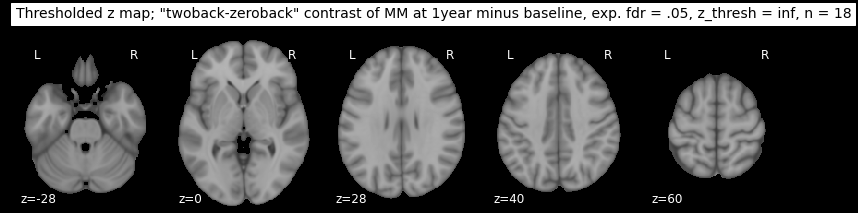

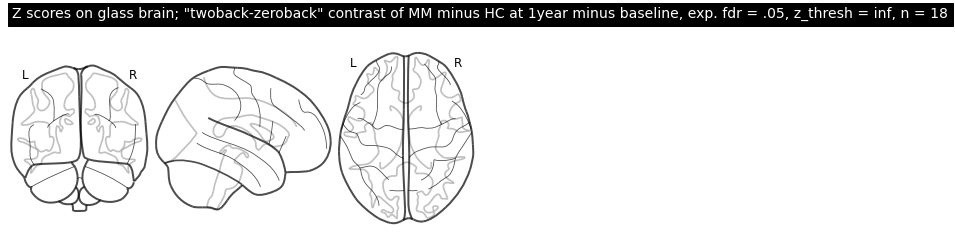

In [41]:
sessions=['1year','baseline']
contrasts=['twoback-zeroback']
task='nback'
group='MM'
#covariates_list = [[],['sex'],['age'],['THC_freq_month'],['total_cudit'],['age','sex'],['THC_freq_month','age','sex'],['total_cudit','age','sex'] ]
covariates_list = [['age','sex']]
space='MNI152NLin6Asym' #change if desired
MNI_template_used = nibabel.load('./templates/tpl-MNI152NLin6Asym_res-01_desc-brain_T1w.nii.gz')


for covariates in covariates_list:
    for contrast in contrasts:
        contrast_output, mask, part_count = get_MM_paired_group_difference_contrast(contrast,sessions,group,task,covariates)

        #calculate fdr-thresholded map
        threshold_map, threshold = fdr_threshold_map(contrast_output['z_score'], mask)

        #make visualizations
        axial_slices = plot_axial_slices(threshold_map, threshold, MNI_template_used, contrast, group, '1year minus baseline', part_count)
        glass_brain = plot_glass_brains(threshold_map, threshold, contrast, 'MM minus HC', '1year minus baseline', part_count)

    